## Face blurring

Isthmus / Mitchellpkt

Leveraging some code from https://realpython.com/traditional-face-detection-python/

## Install libraries

In [1]:
#!pip install opencv-python
import cv2 as cv
import matplotlib.pyplot as plt

## Import image

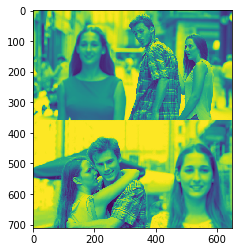

In [2]:
# Read image from your local file system
original_image = cv.imread('testfilehalf.png')
#plt.imshow(original_image)

# Convert color image to grayscale for Viola-Jones
grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
plt.imshow(grayscale_image)

## classifier

In [3]:
# Load the classifier and create a cascade object for face detection
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')

In [4]:
detected_faces = face_cascade.detectMultiScale(grayscale_image)

In [5]:
for (column, row, width, height) in detected_faces:
    cv.rectangle(
        original_image,
        (column, row),
        (column + width, row + height),
        (0, 255, 0),
        2
    )

In [ ]:
cv.imshow('Image', original_image)
cv.waitKey(0)
cv.destroyAllWindows()
